# Super Resolution

**Description:** Image segmentation model trained from scratch on the Oxford Pets dataset.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#@title ## Models { display-mode: "form" }
#@markdown Main imports, global variables, models and function definitions

# colab forms tutorial
# https://colab.research.google.com/notebooks/forms.ipynb#scrollTo=ZCEBZPwUDGOg

import tensorflow as tf

import numpy as np
import os
import matplotlib.pyplot as plt
import random

from io import BytesIO
from urllib.request import urlopen, Request

seed = 42
img_size = (256,256) #gt_image size, and network output size
down_factor = 4
preprocess_data = True # turn False if you have ready your data
data_augmentation = True
BATCH_SIZE = 1
num_classes = 3

downscale_img_size = (img_size[0]//down_factor, img_size[1]//down_factor)
up_factor = down_factor

def set_seed(seedValue=42):
  """Sets the seed on multiple python modules to obtain results as
  reproducible as possible.
  Args:
  seedValue (int, optional): seed value.
  """
  np.random.seed(seed=seedValue)
  tf.random.set_seed(seedValue)
  os.environ["PYTHONHASHSEED"]=str(seedValue)
  random.seed(seedValue)
set_seed(seed)
print("Tensorflow version: ", tf.__version__ )

####################
###### Models ######
####################

from tensorflow.keras.layers import Input, Conv2D, Activation, Add, Lambda, GlobalAveragePooling2D, Multiply, Dense, Reshape
from tensorflow.keras.models import Model
# Network definitions
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, UpSampling2D, Activation, Multiply
from tensorflow.keras.layers import Dropout, BatchNormalization, SpatialDropout2D
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, SeparableConv2D, Dense
from tensorflow.keras.layers import AveragePooling2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Concatenate, Add, concatenate, Lambda, Reshape
from tensorflow.nn import depth_to_space

# Sub-pixel layer for learnable upsampling
# From: https://github.com/twairball/keras-subpixel-conv/blob/master/subpixel.py
def SubpixelConv2D(input_shape, scale=4):
    """
    Keras layer to do subpixel convolution.
    NOTE: Tensorflow backend only. Uses tf.depth_to_space
    Ref:
        [1] Real-Time Single Image and Video Super-Resolution Using an Efficient Sub-Pixel Convolutional Neural Network
            Shi et Al.
            https://arxiv.org/abs/1609.05158
    :param input_shape: tensor shape, (batch, height, width, channel)
    :param scale: upsampling scale. Default=4
    :return:
    """
    # upsample using depth_to_space
    def subpixel_shape(input_shape):
        dims = [input_shape[0],
                input_shape[1] * scale,
                input_shape[2] * scale,
                int(input_shape[3] / (scale ** 2))]
        output_shape = tuple(dims)
        return output_shape

    def subpixel(x):
        return depth_to_space(x, scale)


    #return Lambda(subpixel, output_shape=subpixel_shape, name='subpixel')
    return Lambda(subpixel, output_shape=subpixel_shape)

def upsample(x, out_channels=16, method='Upsampling2D', upsampling_factor=2,
             input_shape=None):
    if method == 'Conv2DTranspose':
        if input_shape is None:
            x = Conv2DTranspose(out_channels, (2, 2),
                                strides=(upsampling_factor, upsampling_factor),
                                padding='same') (x)
        else:
            x = Conv2DTranspose(out_channels, (2, 2),
                                strides=(upsampling_factor, upsampling_factor),
                                padding='same', input_shape=input_shape) (x)
    elif method == 'Upsampling2D':
        x = UpSampling2D( size=(upsampling_factor, upsampling_factor) )( x )
        x = Conv2D(out_channels, (3, 3), padding='same')(x)
    elif method == 'SubpixelConv2D':
        x = Conv2D(out_channels * upsampling_factor ** 2, (3, 3),
                   padding='same')(x)
        x = SubpixelConv2D( input_shape, scale=upsampling_factor )(x)
    else:
        x = UpSampling2D( size=(upsampling_factor, upsampling_factor) )( x )

    return x
# Regular U-Net
def UNet_part(inputs,
         filters=16,
         activation='elu',
         kernel_initializer = 'he_normal',
         dropout_value=0.2,
         average_pooling=True,
         spatial_dropout=False,
         pixel_shuffle = False):
  """
  regular U-Net structure
       Args:
            filters (int, optional): number of channels at the first level of U-Net
            activation (str, optional): Keras available activation type.
            kernel_initializer (str, optional): Keras available kernel 
                initializer type.
            dropout_value (real value/list/None, optional): dropout value of each
                level and the bottleneck
            average_pooling (bool, optional): use average-pooling between U-Net
                levels (otherwise use max pooling).
            spatial_dropout (bool, optional): use SpatialDroput2D, otherwise regular Dropout
       Returns:
            model (Keras model): model containing the ResUNet created.
  """
  # make a list of dropout values if needed
  if type( dropout_value ) is float:
            dropout_value = [dropout_value]*5

  conv1 = Conv2D(filters, (3,3), activation = activation, padding = 'same', kernel_initializer = kernel_initializer)(inputs)
  conv1 = SpatialDropout2D(dropout_value[0], seed=seed)(conv1) if spatial_dropout else Dropout(dropout_value[0], seed=seed) (conv1)
  conv1 = Conv2D(filters, (3,3), activation = activation, padding = 'same', kernel_initializer = kernel_initializer)(conv1)
  pool1 = AveragePooling2D(pool_size=(2, 2))(conv1) if average_pooling else MaxPooling2D(pool_size=(2, 2))(conv1)
  
  conv2 = Conv2D(filters*2, (3,3), activation = activation, padding = 'same', kernel_initializer = kernel_initializer)(pool1)
  conv2 = SpatialDropout2D(dropout_value[1], seed=seed)(conv2) if spatial_dropout else Dropout(dropout_value[1], seed=seed) (conv2)
  conv2 = Conv2D(filters*2, (3,3), activation = activation, padding = 'same', kernel_initializer = kernel_initializer)(conv2)
  pool2 = AveragePooling2D(pool_size=(2, 2))(conv2) if average_pooling else MaxPooling2D(pool_size=(2, 2))(conv2)
  
  conv3 = Conv2D(filters*4, (3,3), activation = activation, padding = 'same', kernel_initializer = kernel_initializer)(pool2)
  conv3 = SpatialDropout2D(dropout_value[2], seed=seed)(conv3) if spatial_dropout else Dropout(dropout_value[2], seed=seed) (conv3)
  conv3 = Conv2D(filters*4, (3,3), activation = activation, padding = 'same', kernel_initializer = kernel_initializer)(conv3)
  pool3 = AveragePooling2D(pool_size=(2, 2))(conv3) if average_pooling else MaxPooling2D(pool_size=(2, 2))(conv3)
  
  conv4 = Conv2D(filters*8, (3,3), activation = activation, padding = 'same', kernel_initializer = kernel_initializer)(pool3)
  conv4 = SpatialDropout2D(dropout_value[3], seed=seed)(conv4) if spatial_dropout else Dropout(dropout_value[3], seed=seed)(conv4)
  conv4 = Conv2D(filters*8, (3,3), activation = activation, padding = 'same', kernel_initializer = kernel_initializer)(conv4)
  pool4 = AveragePooling2D(pool_size=(2, 2))(conv4) if average_pooling else MaxPooling2D(pool_size=(2, 2))(conv4)

  conv5 = Conv2D(filters*16, (3,3), activation = activation, padding = 'same', kernel_initializer = kernel_initializer)(pool4)
  conv5 = SpatialDropout2D(dropout_value[4], seed=seed)(conv5) if spatial_dropout else Dropout(dropout_value[4], seed=seed)(conv5)
  conv5 = Conv2D(filters*16, (3,3), activation = activation, padding = 'same', kernel_initializer = kernel_initializer)(conv5)
  
  up6 = tf.nn.depth_to_space(conv5, 2) if pixel_shuffle else Conv2DTranspose(filters*8, (2, 2), strides=(2, 2), padding='same') (conv5)  
  merge6 = concatenate([conv4,up6], axis = 3)
  conv6 = Conv2D(filters*8, (3,3), activation = activation, padding = 'same', kernel_initializer = kernel_initializer)(merge6)
  conv6 = SpatialDropout2D(dropout_value[3], seed=seed)(conv6) if spatial_dropout else Dropout(dropout_value[3], seed=seed)(conv6)
  conv6 = Conv2D(filters*8, (3,3), activation = activation, padding = 'same', kernel_initializer = kernel_initializer)(conv6)

  up7 = tf.nn.depth_to_space(conv6, 2) if pixel_shuffle else Conv2DTranspose(filters*4, (2, 2), strides=(2, 2), padding='same') (conv6)
  merge7 = concatenate([conv3,up7], axis = 3)
  conv7 = Conv2D(filters*4, (3,3), activation = activation, padding = 'same', kernel_initializer = kernel_initializer)(merge7)
  conv7 = SpatialDropout2D(dropout_value[2], seed=seed)(conv7) if spatial_dropout else Dropout(dropout_value[2], seed=seed)(conv7)
  conv7 = Conv2D(filters*4, (3,3), activation = activation, padding = 'same', kernel_initializer = kernel_initializer)(conv7)
  
  up8 = tf.nn.depth_to_space(conv7, 2) if pixel_shuffle else Conv2DTranspose(filters*2, (2, 2), strides=(2, 2), padding='same') (conv7)
  merge8 = concatenate([conv2,up8], axis = 3)
  conv8 = Conv2D(filters*2, (3,3), activation = activation, padding = 'same', kernel_initializer = kernel_initializer)(merge8)
  conv8 = SpatialDropout2D(dropout_value[1], seed=seed)(conv8) if spatial_dropout else Dropout(dropout_value[1], seed=seed)(conv8)
  conv8 = Conv2D(filters*2, (3,3), activation = activation, padding = 'same', kernel_initializer = kernel_initializer)(conv8)
  
  up9 = tf.nn.depth_to_space(conv8, 2) if pixel_shuffle else Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same') (conv8)
  merge9 = concatenate([conv1,up9], axis = 3)
  conv9 = Conv2D(filters, (3,3), activation = activation, padding = 'same', kernel_initializer = kernel_initializer)(merge9)
  conv9 = SpatialDropout2D(dropout_value[0], seed=seed)(conv9) if spatial_dropout else Dropout(dropout_value[0], seed=seed)(conv9)
  conv9 = Conv2D(filters, (3,3), activation = activation, padding = 'same', kernel_initializer = kernel_initializer)(conv9)

  return conv9

def preUNet4(input_size = (None,None,3),
            filters=16,
            activation='elu',
            kernel_initializer = 'he_normal',
            dropout_value=0.2,
            average_pooling=True,
            spatial_dropout=False,
            pixel_shuffle = False,
            upsampling_factor=2,
            upsample_method='UpSampling2D'):

  inputs = Input( input_size )
  
  s = upsample( inputs, out_channels=filters, method=upsample_method,
                     upsampling_factor=upsampling_factor,
                     input_shape=(input_size[0], input_size[1], input_size[2]))

  x = UNet_part(s,
         filters=filters,
         activation=activation,
         kernel_initializer = kernel_initializer,
         dropout_value=dropout_value,
         average_pooling=average_pooling,
         spatial_dropout=spatial_dropout,
         pixel_shuffle = pixel_shuffle)

  x = Add()([s,x]) # long shortcut
  outputs = Conv2D(input_size[2], (1, 1), activation='linear') (x)
  
  model = Model(inputs=[inputs], outputs=[outputs])
  return model

def postUNet4(input_size = (None,None,3),
            filters=16,
            activation='elu',
            kernel_initializer = 'he_normal',
            dropout_value=0.2,
            average_pooling=True,
            spatial_dropout=False,
            pixel_shuffle = False,
            upsampling_factor=2,
            upsample_method='UpSampling2D'):

  inputs = Input( input_size )
  
  conv9 = UNet_part(inputs,
         filters=filters,
         activation=activation,
         kernel_initializer = kernel_initializer,
         dropout_value=dropout_value,
         average_pooling=average_pooling,
         spatial_dropout=spatial_dropout,
         pixel_shuffle = pixel_shuffle)

  conv9 = upsample( conv9, out_channels=1, method=upsample_method,
                    upsampling_factor=upsampling_factor,
                    input_shape=(input_size[0], input_size[1], input_size[2]))

  #outputs = Conv2D(1, (1, 1), activation='sigmoid') (conv9)
  outputs = Conv2D(1, (1, 1)) (conv9)

  model = Model(inputs=[inputs], outputs=[outputs])
  return model

# == Residual U-Net ==

def residual_block(x, dim, filter_size, activation='elu', 
                   kernel_initializer='he_normal', dropout_value=0.2, bn=False,
                   first_conv_strides=1, separable_conv=False, firstBlock=False):

    # Create shorcut
    if firstBlock == False:
        shortcut = Conv2D(dim, activation=None, kernel_size=(1, 1), 
                      strides=first_conv_strides)(x)
    else:
        shortcut = Conv2D(dim, activation=None, kernel_size=(1, 1), 
                      strides=1)(x)
    
    # Main path
    if firstBlock == False:
        x = BatchNormalization()(x) if bn else x
        x = Activation( activation )(x)
    if separable_conv == False:
        if firstBlock == True:
            x = Conv2D(dim, filter_size, strides=1, activation=None,
                kernel_initializer=kernel_initializer, padding='same') (x)
        else:
            x = Conv2D(dim, filter_size, strides=first_conv_strides, activation=None,
                kernel_initializer=kernel_initializer, padding='same') (x)
    else:
        x = SeparableConv2D(dim, filter_size, strides=first_conv_strides, 
                            activation=None, kernel_initializer=kernel_initializer,
                            padding='same') (x)
    x = SpatialDropout2D( dropout_value, seed=seed ) (x) if dropout_value else x
    x = BatchNormalization()(x) if bn else x
    x = Activation( activation )(x)
      
    if separable_conv == False:
        x = Conv2D(dim, filter_size, activation=None,
                kernel_initializer=kernel_initializer, padding='same') (x)
    else:
        x = SeparableConv2D(dim, filter_size, activation=None,
                kernel_initializer=kernel_initializer, padding='same') (x)

    # Add shortcut value to main path
    x = Add()([shortcut, x])
    print( 'residual block, dim: ' + str(dim) + ' , output shape: '+ str(x.shape) )
    return x

def level_block(x, depth, dim, fs, ac, k, d, bn, fcs, sc, fb, mp, ps):

    if depth > 0:
        r = residual_block(x, dim, fs, ac, k, d, bn, fcs, sc, fb)
        x = MaxPooling2D((2, 2)) (r) if mp else r
        x = level_block(x, depth-1, (dim*2), fs, ac, k, d, bn, fcs, sc, False, mp, ps) 
        x = tf.nn.depth_to_space(x, 2) if ps else  Conv2DTranspose(dim, (2, 2), strides=(2, 2), padding='same') (x)
        x = Concatenate()([r, x])
        x = residual_block(x, dim, fs, ac, k, d, bn, 1, sc, False)
    else:
        x = residual_block(x, dim, fs, ac, k, d, bn, fcs, sc, False)
    return x


def preResUNet(image_shape, activation='elu', kernel_initializer='he_normal',
            dropout_value=0.2, batchnorm=False, maxpooling=True, separable=False,
            numInitChannels=16, depth=4, upsampling_factor=2,
            upsample_method='UpSampling2D', final_activation=None,
            pixel_shuffle = False):

    """Create the pre-upsampling ResU-Net for super-resolution
       Args:
            image_shape (array of 3 int): dimensions of the input image.
            activation (str, optional): Keras available activation type.
            kernel_initializer (str, optional): Keras available kernel 
            initializer type.
            dropout_value (real value, optional): dropout value
            batchnorm (bool, optional): use batch normalization
            maxpooling (bool, optional): use max-pooling between U-Net levels 
            (otherwise use stride of 2x2).
            separable (bool, optional): use SeparableConv2D instead of Conv2D
            numInitChannels (int, optional): number of channels at the
            first level of U-Net
            depth (int, optional): number of U-Net levels
            upsampling_factor (int, optional): initial image upsampling factor
            upsample_method (str, optional): upsampling method to use
            ('UpSampling2D', 'Conv2DTranspose', or 'SubpixelConv2D')
            final_activation (str, optional): activation function for the last
            layer
       Returns:
            model (Keras model): model containing the ResUNet created.
    """

    inputs = Input(image_shape) #(None, None, image_shape[2])

    s = upsample( inputs, out_channels=numInitChannels, method=upsample_method,
                  upsampling_factor=upsampling_factor,
                  input_shape=(image_shape[0], image_shape[1], image_shape[2]))

    conv_strides = (1,1) if maxpooling else (2,2)

    x = level_block(s, depth, numInitChannels, 3, activation, kernel_initializer,
                    dropout_value, batchnorm, conv_strides, separable, True,
                    maxpooling, pixel_shuffle)

    #outputs = Conv2D(1, (1, 1), activation='sigmoid') (x)

    x = Add()([s,x]) # long shortcut

    outputs = Conv2D(image_shape[2], (1, 1), activation=final_activation) (x)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model
def postResUNet(image_shape, activation='elu', kernel_initializer='he_normal',
            dropout_value=0.2, batchnorm=False, maxpooling=True, separable=False,
            numInitChannels=16, depth=4, upsampling_factor=2,
            upsample_method='UpSampling2D', final_activation=None,
            pixel_shuffle = False ):

    """Create the post-upsampling ResU-Net for super-resolution
       Args:
            image_shape (array of 3 int): dimensions of the input image.
            activation (str, optional): Keras available activation type.
            kernel_initializer (str, optional): Keras available kernel 
            initializer type.
            dropout_value (real value, optional): dropout value
            batchnorm (bool, optional): use batch normalization
            maxpooling (bool, optional): use max-pooling between U-Net levels 
            (otherwise use stride of 2x2).
            separable (bool, optional): use SeparableConv2D instead of Conv2D
            numInitChannels (int, optional): number of channels at the
            first level of U-Net
            depth (int, optional): number of U-Net levels
            upsampling_factor (int, optional): initial image upsampling factor
            upsample_method (str, optional): upsampling method to use
            ('UpSampling2D', 'Conv2DTranspose', or 'SubpixelConv2D')
            final_activation (str, optional): activation function for the last
            layer
       Returns:
            model (Keras model): model containing the ResUNet created.
    """

    inputs = Input(image_shape) #(None, None, image_shape[2])

    conv_strides = (1,1) if maxpooling else (2,2)

    x = level_block(inputs, depth, numInitChannels, 3, activation, kernel_initializer,
                    dropout_value, batchnorm, conv_strides, separable, True,
                    maxpooling, pixel_shuffle)

    x = upsample( x, out_channels=numInitChannels, method=upsample_method,
                  upsampling_factor=upsampling_factor,
                  input_shape=(image_shape[0], image_shape[1], image_shape[2]))
    

    #outputs = Conv2D(1, (1, 1), activation='sigmoid') (x)
    outputs = Conv2D(image_shape[2], (1, 1), activation=final_activation) (x)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model
def prePostResUNet(image_shape, activation='elu', kernel_initializer='he_normal',
            dropout_value=0.2, batchnorm=False, maxpooling=True, separable=False,
            numInitChannels=16, depth=4, upsampling_factor=2,
            upsample_method='UpSampling2D', final_activation='linear',
            pixel_shuffle = False ):

    """Create the pre- and post-upsampling ResU-Net for super-resolution
       Args:
            image_shape (array of 3 int): dimensions of the input image.
            activation (str, optional): Keras available activation type.
            kernel_initializer (str, optional): Keras available kernel 
            initializer type.
            dropout_value (real value, optional): dropout value
            batchnorm (bool, optional): use batch normalization
            maxpooling (bool, optional): use max-pooling between U-Net levels 
            (otherwise use stride of 2x2).
            separable (bool, optional): use SeparableConv2D instead of Conv2D
            numInitChannels (int, optional): number of channels at the
            first level of U-Net
            depth (int, optional): number of U-Net levels
            upsampling_factor (int, optional): initial image upsampling factor
            upsample_method (str, optional): upsampling method to use
            ('UpSampling2D', 'Conv2DTranspose', or 'SubpixelConv2D')
            final_activation (str, optional): activation function for the last
            layer
       Returns:
            model (Keras model): model containing the ResUNet created.
    """

    inputs = Input(image_shape) #(None, None, image_shape[2])
    
    s = upsample( inputs, out_channels=numInitChannels, method=upsample_method,
                  upsampling_factor=upsampling_factor/2,
                  input_shape=(image_shape[0], image_shape[1], image_shape[2]))

    conv_strides = (1,1) if maxpooling else (2,2)

    x = level_block(s, depth, numInitChannels, 3, activation, kernel_initializer,
                    dropout_value, batchnorm, conv_strides, separable, True,
                    maxpooling, pixel_shuffle)

    x = upsample( x, out_channels=numInitChannels, method=upsample_method,
                  upsampling_factor=upsampling_factor/2,
                  input_shape=(image_shape[0], image_shape[1], image_shape[2]))
    

    #outputs = Conv2D(1, (1, 1), activation='sigmoid') (x)
    outputs = Conv2D(image_shape[2], (1, 1), activation=final_activation) (x)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

Tensorflow version:  2.5.0


In [3]:
#@title ## Load model weights { display-mode: "form" }

# learning rate
lr = 1e-3
# initial filters
num_init_ch = 16

loss_funct = 'mean_squared_error'
optim = tf.keras.optimizers.RMSprop( learning_rate=lr )
input_size = img_size + (3,)

model = preResUNet( numInitChannels=num_init_ch,
        image_shape = downscale_img_size + (3,), 
        upsampling_factor = up_factor,
        dropout_value=0.2, # spatial_dropout(dropout_value) if dropout_value
        upsample_method = "SubpixelConv2D",
        final_activation = 'linear',
        activation="elu",
        pixel_shuffle = False)


model_path = '/content/drive/MyDrive/TFG/models/SR-weights-preResUNet-nf-16-MSE-bs-1-rmsprop-reduce.h5'#@param {type:"string"}

model.load_weights(model_path)
model.compile(optimizer=optim, loss=loss_funct, metrics=[loss_funct])

#@markdown ---
#@markdown **(beta)**
show_model_architecture = False #@param {type:"boolean"}
if show_model_architecture:
    tf.keras.utils.plot_model(model, show_shapes=True)

# import everything about the model from 1 file. 
# problem with rcan, due to custom metrics
#model_path = '/content/drive/MyDrive/TFG/models/my_model'
#model = tf.keras.models.load_model(model_path)

residual block, dim: 16 , output shape: (None, 256, 256, 16)
residual block, dim: 32 , output shape: (None, 128, 128, 32)
residual block, dim: 64 , output shape: (None, 64, 64, 64)
residual block, dim: 128 , output shape: (None, 32, 32, 128)
residual block, dim: 256 , output shape: (None, 16, 16, 256)
residual block, dim: 128 , output shape: (None, 32, 32, 128)
residual block, dim: 64 , output shape: (None, 64, 64, 64)
residual block, dim: 32 , output shape: (None, 128, 128, 32)
residual block, dim: 16 , output shape: (None, 256, 256, 16)


In [7]:
#@title ## Display functions { display-mode: "form" }

#################
### Utilities ###
#################

### Functions to display

def display(display_list):
  plt.figure(figsize=(10,5))

  title = ['Imagen de entrada (red SR)', 'Imagen predicha', 'Raw prediction']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    #print(display_list[i]) # raw image values
    #print("---------")
    #plt.axis('off')
  plt.show()

def show_predictions(gt, display_raw_mask = False):
    pred_img = model.predict(gt[tf.newaxis, ...])
    pred_img = np.clip(pred_img, 0, 1)
    images = [gt, pred_img[0]]
    display(images)

### Image preprocess functions

from skimage import filters
from PIL import Image

def classic_crappify(img):
    im = np.asarray(img, dtype=np.float32)
    im = filters.gaussian(im, sigma=3, multichannel=True)
    im = np.rint(im)
    im = np.asarray(im, dtype=np.uint8)
    return Image.fromarray(im)

def sub1(mask):
    # [3,2,1] -> [2,1,0]
    m = np.asarray(mask, dtype=np.uint8) - 1
    return Image.fromarray(m)

# input: PIL image object
# output: numpy array
def image_preprocess(image):
    # Convert (RGBA,...) images to RGB
    if image.mode != 'RGB':
        image = image.convert('RGB')

    # Apply moddifications (crappify, resize, ...)
    
    gt_img = image.resize(img_size, Image.BILINEAR)
    gt_img = classic_crappify(gt_img)
    gt_img = gt_img.resize(downscale_img_size, Image.BILINEAR)
    
    gt_img = np.asanyarray(gt_img, dtype=np.float32) / 255 # normalize

    return gt_img
#b = image_preprocess(a)
#print(np.max(b), np.min(b))
#display([b])

Image correctly downloaded.
Processing...



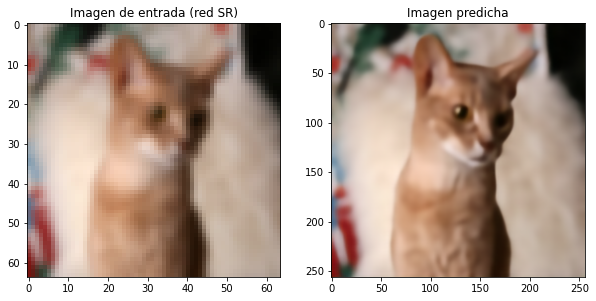

In [8]:
#@title ## Local images { display-mode: "form" }
img_path = "/content/Abyssinian_143.jpg"#@param {type:"string"}
images = [img_path]
all_images = False #@param {type:"boolean"}

if all_images:
    from glob import glob
    images = glob("/content/*.jpg")


for img_path in images:
    img = Image.open(img_path) 
    input = image_preprocess(img)

    #file_url = "" # clean input
    print("Image correctly downloaded.\nProcessing...\n")
    # plt.imshow(np.asarray(img)) # original image

    raw_mask = False #@param {type:"boolean"}
    show_predictions(input, raw_mask)

https://catpedia.net/wp-content/uploads/2018/01/Bengal-cat.jpg,https://www.mascotahogar.com/1920x1080/wallpaper-de-un-caballo-salvaje.jpg,https://www.pixelstalk.net/wp-content/uploads/2016/03/Volorful-parrot-animal-wallpaper-HD.jpg,https://www.pixelstalk.net/wp-content/uploads/images2/Screen-Download-Animal-Wallpapers.jpg,https://www.pixelstalk.net/wp-content/uploads/2016/03/Animals-wallpaper-HD-background.jpg,https://www.pixelstalk.net/wp-content/uploads/2016/03/Animals-wallpaper-HD-desktop.jpg,https://www.pixelstalk.net/wp-content/uploads/2016/03/Animal-wallpaper-HD-for-free.jpg,https://www.pixelstalk.net/wp-content/uploads/2016/03/Animal-wallpapers-HD-desktop.jpg,https://www.pixelstalk.net/wp-content/uploads/2016/03/Animals-Birds-Wallpaper-HD-1920x1080.jpg,https://www.pixelstalk.net/wp-content/uploads/2016/03/Animal-wallpapers-HD-free-download.jpg,https://tailandfur.com/wp-content/uploads/2014/09/beautiful-and-cute-animals-wallpaper-51.jpg,https://4.bp.blogspot.com/-CO5-mntxeWo/Tvc3bTvFLTI/AAAAAAAAT18/H0Zu1zr_ITM/s1600/animals-widescreen-wallpapers-animals.jpg,https://3.bp.blogspot.com/-Gf-f7GSnp8U/Tvc3auZfg8I/AAAAAAAAT1s/zaWFB9tHT3c/s1600/Animals%2BWallpapers.jpg,https://1.bp.blogspot.com/_UmpGmlMW_Ek/TKJil9BMv_I/AAAAAAAAAAU/HgflMrUMvX8/w1200-h630-p-k-no-nu/bicicletas+specialized.jpg,https://astelus.com/wp-content/viajes/paisaje-marino-lago-jackson.jpg,http://dibujos.drawing-of.eu/wp-content/uploads/2017/03/kot.jpg,https://i2.wp.com/consciouscat.net/wp-content/uploads/2015/11/kitten-drawing.jpg,https://www.masscience.com/wp-content/uploads/2016/01/infinito.jpg,https://i.pinimg.com/originals/aa/96/94/aa9694a73702278c3b09aadfeecef7e4.jpg,https://i.ytimg.com/vi/H6Iq-pTxbAs/hqdefault.jpg

In [ ]:
#@title ## ¡¡ TEST IT !! { display-mode: "form" }

a = 0
#@markdown ### Enter an image url:
file_url = "https://catpedia.net/wp-content/uploads/2018/01/Bengal-cat.jpg,https://www.mascotahogar.com/1920x1080/wallpaper-de-un-caballo-salvaje.jpg,https://www.pixelstalk.net/wp-content/uploads/2016/03/Volorful-parrot-animal-wallpaper-HD.jpg,https://www.pixelstalk.net/wp-content/uploads/images2/Screen-Download-Animal-Wallpapers.jpg,https://www.pixelstalk.net/wp-content/uploads/2016/03/Animals-wallpaper-HD-background.jpg,https://www.pixelstalk.net/wp-content/uploads/2016/03/Animals-wallpaper-HD-desktop.jpg,https://www.pixelstalk.net/wp-content/uploads/2016/03/Animal-wallpaper-HD-for-free.jpg,https://www.pixelstalk.net/wp-content/uploads/2016/03/Animal-wallpapers-HD-desktop.jpg,https://www.pixelstalk.net/wp-content/uploads/2016/03/Animals-Birds-Wallpaper-HD-1920x1080.jpg,https://www.pixelstalk.net/wp-content/uploads/2016/03/Animal-wallpapers-HD-free-download.jpg,https://tailandfur.com/wp-content/uploads/2014/09/beautiful-and-cute-animals-wallpaper-51.jpg,https://4.bp.blogspot.com/-CO5-mntxeWo/Tvc3bTvFLTI/AAAAAAAAT18/H0Zu1zr_ITM/s1600/animals-widescreen-wallpapers-animals.jpg,https://3.bp.blogspot.com/-Gf-f7GSnp8U/Tvc3auZfg8I/AAAAAAAAT1s/zaWFB9tHT3c/s1600/Animals%2BWallpapers.jpg,https://1.bp.blogspot.com/_UmpGmlMW_Ek/TKJil9BMv_I/AAAAAAAAAAU/HgflMrUMvX8/w1200-h630-p-k-no-nu/bicicletas+specialized.jpg,https://astelus.com/wp-content/viajes/paisaje-marino-lago-jackson.jpg,http://dibujos.drawing-of.eu/wp-content/uploads/2017/03/kot.jpg,https://i2.wp.com/consciouscat.net/wp-content/uploads/2015/11/kitten-drawing.jpg,https://www.masscience.com/wp-content/uploads/2016/01/infinito.jpg,https://i.pinimg.com/originals/aa/96/94/aa9694a73702278c3b09aadfeecef7e4.jpg,https://i.ytimg.com/vi/H6Iq-pTxbAs/hqdefault.jpg" #@param {type:"string"}
#@markdown ---

# Simulate a User-Agent header value.
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.3'}

def process_image(url):
    # Send request with simulated User-Agent header. 
    req = Request(url=url, headers=headers)

    try:
        with urlopen(req) as response:
            c = response.read()
        img = Image.open(BytesIO(c))
        a=img
        input = image_preprocess(img)
        
        #file_url = "" # clean input
        print("Image correctly downloaded.\nProcessing...\n")
        # plt.imshow(np.asarray(img)) # original image
        show_predictions(input)
    except Exception as e:
        print(e)
        #print("ERROR, please change the url.\n\n", e)
    return a



### MAIN PART
urls = file_url.split(",")
for i,url in enumerate(urls):
    print("\n -- Image {}/{}".format(i+1,len(urls)))
    print(url)
    a = process_image(url)


Output hidden; open in https://colab.research.google.com to view.